In [1]:
import pandas as pd
import numpy as np
 
# To remove the scientific notation from numpy arrays
np.set_printoptions(suppress=True)
 
# install the nsepy library to get stock prices
!pip install nsepy
 


In [7]:
# Getting Stock data using nsepy library
from nsepy import get_history
from datetime import datetime
 
startDate=datetime(2020, 1,1)
endDate=datetime(2022, 10, 5)
 
# Fetching the data
StockData=get_history(symbol='INFY', start=startDate, end=endDate)
print(StockData.shape)
StockData.head()

(634, 14)


,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2020-01-01,INFY,EQ,731.15,735.0,740.0,732.55,739.35,736.85,735.35,2112415,1.553369e+14,36769,561646,0.2659
2020-01-02,INFY,EQ,736.85,738.9,740.8,730.90,735.75,734.70,735.22,5658200,4.160025e+14,102483,3413440,0.6033
2020-01-03,INFY,EQ,734.70,733.9,748.0,733.90,745.00,746.00,744.67,7882938,5.870173e+14,105632,3682521,0.4672
2020-01-06,INFY,EQ,746.00,746.1,753.8,736.50,738.50,738.85,743.51,6519403,4.847237e+14,129992,2871332,0.4404
2020-01-07,INFY,EQ,738.85,738.0,742.6,725.10,729.30,727.90,734.63,7899363,5.803120e+14,189680,3976564,0.5034


<AxesSubplot:xlabel='TradeDate'>

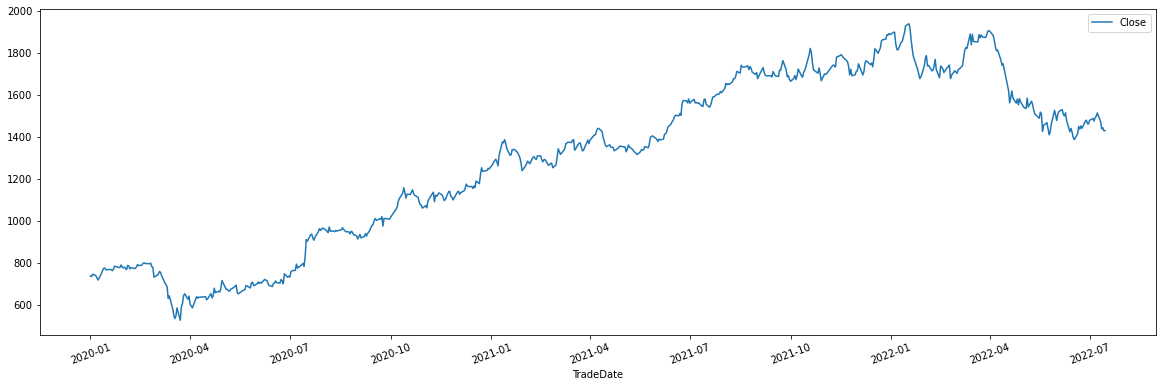

In [8]:

# Creating a column as date
StockData['TradeDate']=StockData.index
 
# Plotting the stock prices
%matplotlib inline
StockData.plot(x='TradeDate', y='Close', kind='line', figsize=(20,6), rot=20)

In [9]:

# Extracting the closing prices of each day
FullData=StockData[['Close']].values
print(FullData[0:5])
 
# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
# Choosing between Standardization or normalization
#sc = StandardScaler()
sc=MinMaxScaler()
 
DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData
 
print('### After Normalization ###')
X[0:5]

[[736.85]
 [734.7 ]
 [746.  ]
 [738.85]
 [727.9 ]]
### After Normalization ###


array([[0.14889777],
       [0.14737624],
       [0.15537313],
       [0.15031315],
       [0.14256396]])

In [10]:
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=10  # next day's Price Prediction is based on last how many past day's prices
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
 
################################################
# Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('\n#### Input Data shape ####')
print(X_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)


#### Input Data shape ####
(624, 10, 1)

#### Output Data shape ####
(624, 1)


In [11]:
TestingRecords=5
 
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
############################################
 
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)



#### Training Data shape ####
(619, 10, 1)
(619, 1)

#### Testing Data shape ####
(5, 10, 1)
(5, 1)


In [12]:

# Visualizing the input and output being sent to the LSTM model
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp,'--', out)

[[0.14889777]
 [0.14737624]
 [0.15537313]
 [0.15031315]
 [0.14256396]
 [0.13569937]
 [0.14231627]
 [0.14981777]
 [0.17486996]
 [0.17635611]] -- [0.17062383]
[[0.14737624]
 [0.15537313]
 [0.15031315]
 [0.14256396]
 [0.13569937]
 [0.14231627]
 [0.14981777]
 [0.17486996]
 [0.17635611]
 [0.17062383]] -- [0.1702346]


In [13]:

# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)


Number of TimeSteps: 10
Number of Features: 1


In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
# Adding the output layer
regressor.add(Dense(units = 1))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
##################################################
 
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)
 
EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Epoch 1/100
124/124 [==============================] - 7s 11ms/step - loss: 0.1055
Epoch 2/100
124/124 [==============================] - 1s 11ms/step - loss: 0.0049
Epoch 3/100
124/124 [==============================] - 1s 11ms/step - loss: 0.0028
Epoch 4/100
124/124 [==============================] - 1s 10ms/step - loss: 0.0020
Epoch 5/100
124/124 [==============================] - 1s 10ms/step - loss: 0.0020
Epoch 6/100
124/124 [==============================] - 1s 10ms/step - loss: 0.0018
Epoch 7/100
124/124 [==============================] - 1s 11ms/step - loss: 0.0017
Epoch 8/100
124/124 [==============================] - 1s 10ms/step - loss: 0.0017
Epoch 9/100
124/124 [==============================] - 1s 12ms/step - loss: 0.0017
Epoch 10/100
124/124 [==============================] - 1s 11ms/step - loss: 0.0017
Epoch 11/100
124/124 [==============================] - 1s 11ms/step - loss: 0.0018
Epoch 12/100
124/124 [==============================] - 1s 11ms/step - loss: 0.0018
E

Accuracy: 97.6660666273344


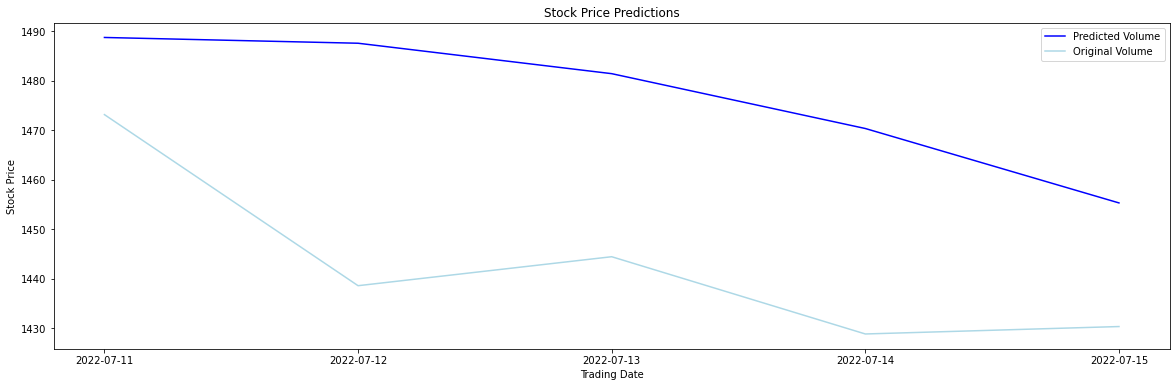

In [15]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)

# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)

# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())

# Visualising the results
import matplotlib.pyplot as plt

plt.plot(predicted_Price, color = 'blue', label = 'Predicted Volume')
plt.plot(orig, color = 'lightblue', label = 'Original Volume')

plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), StockData.tail(TestingRecords)['TradeDate'])
plt.ylabel('Stock Price')

plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

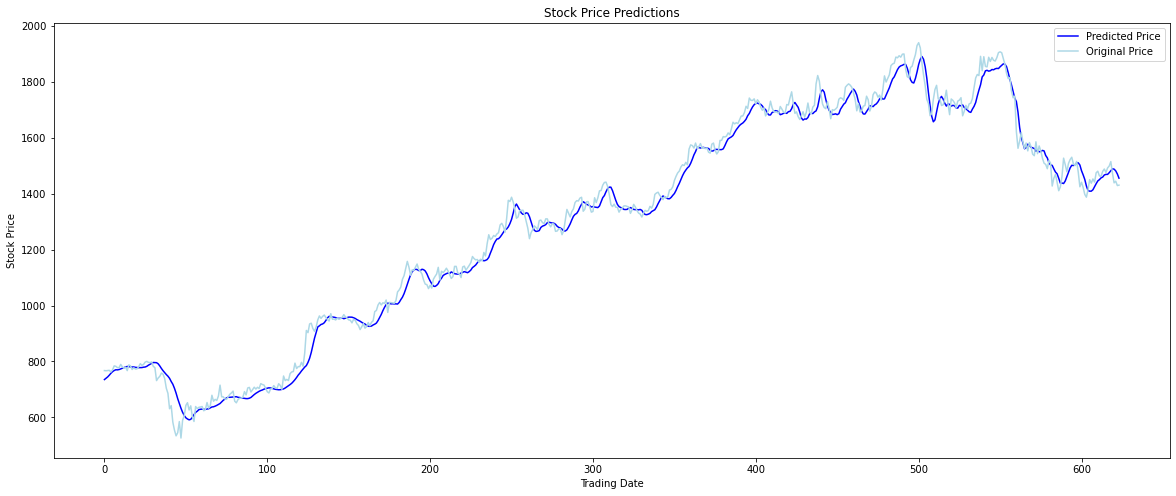

In [16]:
# Generating predictions on full data
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))

FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]

# plotting the full data
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')


plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

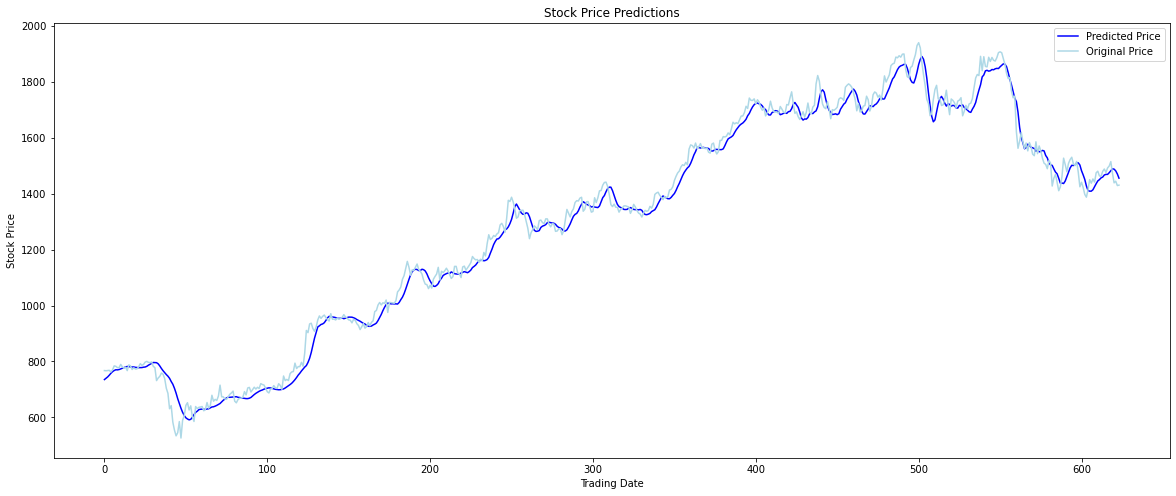

In [17]:
# Generating predictions on full data
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))

FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]

# plotting the full data
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')


plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

## MultiStep LSTM

In [18]:
# Considering the Full Data again which we extracted above
# Printing the last 10 values
print('Original Prices')
print(FullData[-10:])

print('###################')

# Printing last 10 values of the scaled data which we have created above for the last model
# Here I am changing the shape of the data to one dimensional array because
# for Multi step data preparation we need to X input in this fashion
X=X.reshape(X.shape[0],)
print('Scaled Prices')
print(X[-10:])

Original Prices
[[1488.  ]
 [1475.95]
 [1491.65]
 [1498.7 ]
 [1514.45]
 [1473.15]
 [1438.6 ]
 [1444.45]
 [1428.85]
 [1430.35]]
###################
Scaled Prices
[0.6804784  0.67195074 0.68306146 0.68805067 0.69919677 0.66996922
 0.64551856 0.64965854 0.63861859 0.63968012]


In [19]:
# Multi step data preparation

# split into samples
X_samples = list()
y_samples = list()

NumerOfRows = len(X)
TimeSteps=10  # next few day's Price Prediction is based on last how many past day's prices
FutureTimeSteps=5 # How many days in future you want to predict the prices

# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i:i+FutureTimeSteps]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

################################################

# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('### Input Data Shape ###') 
print(X_data.shape)

# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
print('### Output Data Shape ###') 
print(y_data.shape)

### Input Data Shape ###
(619, 10, 1)
### Output Data Shape ###
(619, 5)


In [20]:
# Choosing the number of testing data records
TestingRecords=5

# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

#############################################
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)

print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(614, 10, 1)
(614, 5)

#### Testing Data shape ####
(5, 10, 1)
(5, 5)


In [21]:
# Visualizing the input and output being sent to the LSTM model
# Based on last 10 days prices we are learning the next 5 days of prices
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp)
    print('====>')
    print(out)
    print('#'*20)

[[0.14889777]
 [0.14737624]
 [0.15537313]
 [0.15031315]
 [0.14256396]
 [0.13569937]
 [0.14231627]
 [0.14981777]
 [0.17486996]
 [0.17635611]]
====>
[0.17062383 0.1702346  0.17083613 0.17126075 0.16705   ]
####################
[[0.14737624]
 [0.15537313]
 [0.15031315]
 [0.14256396]
 [0.13569937]
 [0.14231627]
 [0.14981777]
 [0.17486996]
 [0.17635611]
 [0.17062383]]
====>
[0.1702346  0.17083613 0.17126075 0.16705    0.1724992 ]
####################


In [22]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


In [23]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))


# Adding the Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


# Adding the output layer
# Notice the number of neurons in the dense layer is now the number of future time steps 
# Based on the number of future days we want to predict
regressor.add(Dense(units = FutureTimeSteps))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

###################################################################

import time
# Measuring the time taken by the model to train
StartTime=time.time()

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')

Epoch 1/100
123/123 [==============================] - 5s 11ms/step - loss: 0.1169
Epoch 2/100
123/123 [==============================] - 1s 11ms/step - loss: 0.0042
Epoch 3/100
123/123 [==============================] - 1s 12ms/step - loss: 0.0027
Epoch 4/100
123/123 [==============================] - 1s 11ms/step - loss: 0.0026
Epoch 5/100
123/123 [==============================] - 1s 12ms/step - loss: 0.0025
Epoch 6/100
123/123 [==============================] - 1s 12ms/step - loss: 0.0023
Epoch 7/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0023
Epoch 8/100
123/123 [==============================] - 1s 12ms/step - loss: 0.0022
Epoch 9/100
123/123 [==============================] - 1s 12ms/step - loss: 0.0021
Epoch 10/100
123/123 [==============================] - 1s 11ms/step - loss: 0.0022
Epoch 11/100
123/123 [==============================] - 1s 12ms/step - loss: 0.0022
Epoch 12/100
123/123 [==============================] - 1s 11ms/step - loss: 0.0021
E

In [24]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
print('#### Predicted Prices ####')
print(predicted_Price)

# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
print('\n#### Original Prices ####')
print(orig)

#### Predicted Prices ####
[[1482.6913 1482.3196 1484.96   1485.6211 1497.6737]
 [1491.9647 1490.955  1494.2189 1494.9213 1507.0481]
 [1492.476  1491.8098 1495.0472 1495.463  1505.5549]
 [1495.9073 1495.0369 1498.2886 1498.9647 1510.4253]
 [1505.0996 1504.1312 1507.4918 1507.8156 1519.9163]]

#### Original Prices ####
[[1488.   1475.95 1491.65 1498.7  1514.45]
 [1475.95 1491.65 1498.7  1514.45 1473.15]
 [1491.65 1498.7  1514.45 1473.15 1438.6 ]
 [1498.7  1514.45 1473.15 1438.6  1444.45]
 [1514.45 1473.15 1438.6  1444.45 1428.85]]


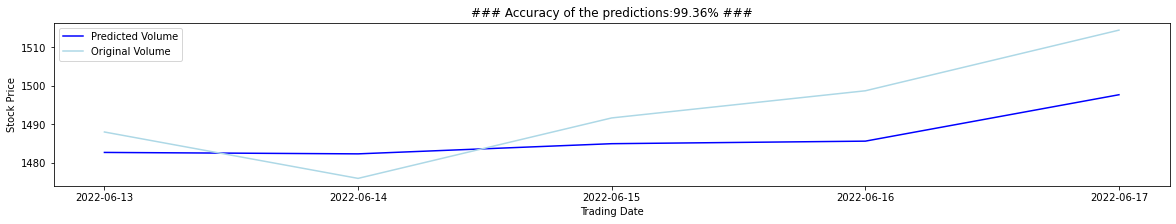

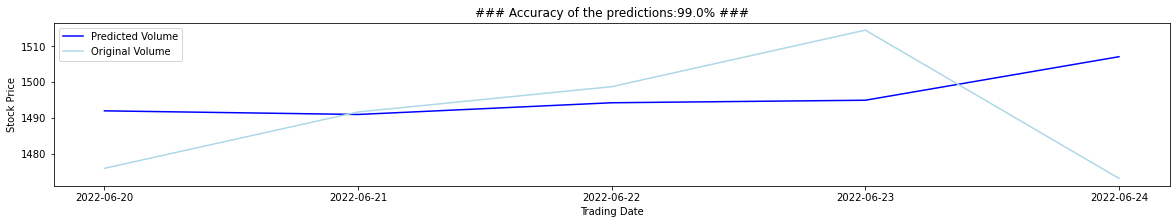

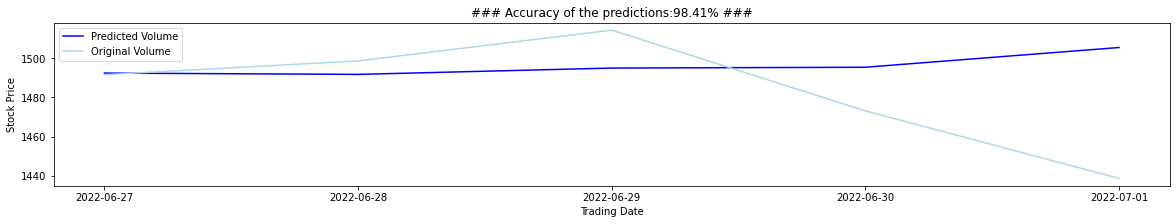

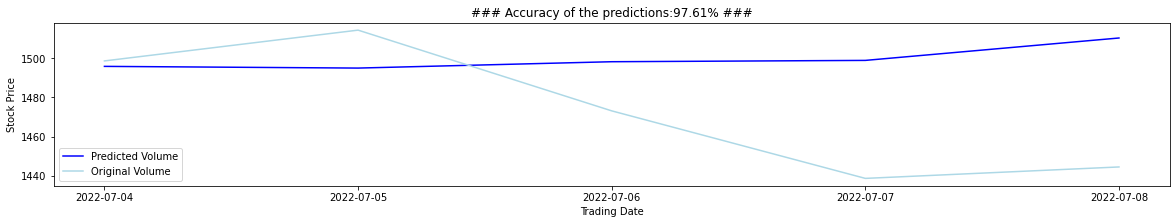

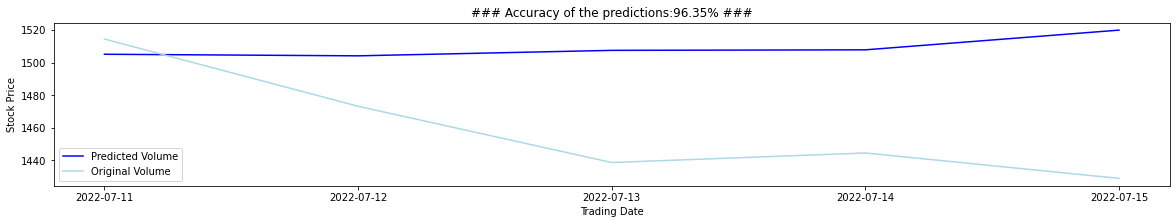

In [25]:
import matplotlib.pyplot as plt

for i in range(len(orig)):
    Prediction=predicted_Price[i]
    Original=orig[i]
    
    # Visualising the results
    plt.plot(Prediction, color = 'blue', label = 'Predicted Volume')
    plt.plot(Original, color = 'lightblue', label = 'Original Volume')

    plt.title('### Accuracy of the predictions:'+ str(100 - (100*(abs(Original-Prediction)/Original)).mean().round(2))+'% ###')
    plt.xlabel('Trading Date')
    
    startDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1)
    endDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1) + FutureTimeSteps
    TotalRows=StockData.shape[0]

    plt.xticks(range(FutureTimeSteps), StockData.iloc[TotalRows-endDateIndex : TotalRows-(startDateIndex) , :]['TradeDate'])
    plt.ylabel('Stock Price')

    plt.legend()
    fig=plt.gcf()
    fig.set_figwidth(20)
    fig.set_figheight(3)
    plt.show()

In [27]:
# Making predictions on test data
Last10DaysPrices=np.array([1376.2, 1371.75,1387.15,1370.5 ,1344.95, 
                   1312.05, 1316.65, 1339.45, 1339.7 ,1340.85])

# Reshaping the data to (-1,1 )because its a single entry
Last10DaysPrices=Last10DaysPrices.reshape(-1, 1)

# Scaling the data on the same level on which model was trained
X_test=DataScaler.transform(Last10DaysPrices)

NumberofSamples=1
TimeSteps=X_test.shape[0]
NumberofFeatures=X_test.shape[1]
# Reshaping the data as 3D input
X_test=X_test.reshape(NumberofSamples,TimeSteps,NumberofFeatures)

# Generating the predictions for next 5 days
Next5DaysPrice = regressor.predict(X_test)

# Generating the prices in original scale
Next5DaysPrice = DataScaler.inverse_transform(Next5DaysPrice)
Next5DaysPrice

array([[1343.753 , 1343.8578, 1347.3718, 1349.3774, 1360.5287]],
      dtype=float32)